# Selecionando Keywords

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## SKU002 - Rosa

In [2]:
SKU002_semana = pd.read_csv('semana.csv', skiprows=9, usecols=lambda column: column != '#')

In [3]:
# A observação 0 é a soma de tudo e deve ser removida.

SKU002_semana = SKU002_semana.drop(0)

Como na primeira semana venda alguma foi realizada e toda correspondência foi ampla, apenas as seguintes colunas são relevantes:
* Tipo de combinação
* Consulta de pesquisa
* Impressão
* Clique
* Despesas

In [4]:
SKU002_semana = SKU002_semana[['Consulta de pesquisa', 'Impressão', 'Cliques', 'Despesas']]

Pode ocorrer de uma mesma Consulta de pesquisa responda às duas Palavras-chave.

In [5]:
# Verificação de reincidência de consulta de pesquisa.

SKU002_semana['Consulta de pesquisa'].value_counts()

Consulta de pesquisa
Blusa De Frio Plus Size          2
parca feminino                   2
cropd de tricô                  2
Blusa de tule gola alta          2
blusa aberta nas costas          2
                                ..
Blusa tecido farm                1
blusinha contry                  1
blusa marga longa                1
Blusinha sueter manga 3 maria    1
animal print                     1
Name: count, Length: 16220, dtype: int64

In [6]:
# Diferença entre o total de item e o número de itens inéditos.
len(SKU002_semana) - len(SKU002_semana['Consulta de pesquisa'].value_counts())

49

In [7]:
# Agrupando pela Consulta de pesquisa e reiniciando o índice.
SKU002_semana = SKU002_semana.groupby('Consulta de pesquisa').agg({'Impressão': 'sum', 'Cliques': 'sum', 'Despesas': 'sum'}).reset_index()

O CTR será calculado a partir dos valores somados.

In [8]:
SKU002_semana['CTR'] = SKU002_semana['Cliques']/SKU002_semana['Impressão']

O custo do clique não é, necessariamente, o valor máximo do lance. Devido a isso, uma nova coluna será criada, mostrando o custo médio dos cliques.

In [9]:
SKU002_semana['Custo Médio'] = SKU002_semana['Despesas']/SKU002_semana['Cliques']

In [10]:
# Ambas as divisões por zero podem criar valores nan.

SKU002_semana.fillna(0,inplace=True)

In [11]:
SKU002_semana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16220 entries, 0 to 16219
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Consulta de pesquisa  16220 non-null  object 
 1   Impressão             16220 non-null  int64  
 2   Cliques               16220 non-null  int64  
 3   Despesas              16220 non-null  float64
 4   CTR                   16220 non-null  float64
 5   Custo Médio           16220 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 760.4+ KB


Os valores de CTR devem estar em float ao invés de string. O CTR pode ser recalculado dividindo Cliques por Impressões, ou os valores podem ser modificados a partir de como estão.

In [12]:
# SKU002_semana['CTR'] = SKU002_semana['CTR'].str.rstrip('%').astype(float)

In [13]:
SKU002_semana.head()

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio
0,0Blusa Feminina Suéter Poncho Modal,1,0,0.0,0.0,0.0
1,0Cardigan Blusa Tricot Feminino Casaco Kimono ...,2,0,0.0,0.0,0.0
2,2023 blusas arrumada,1,0,0.0,0.0,0.0
3,3rd fashion,4,0,0.0,0.0,0.0
4,A branca delicada blusa,1,0,0.0,0.0,0.0


In [14]:
SKU002_semana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16220 entries, 0 to 16219
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Consulta de pesquisa  16220 non-null  object 
 1   Impressão             16220 non-null  int64  
 2   Cliques               16220 non-null  int64  
 3   Despesas              16220 non-null  float64
 4   CTR                   16220 non-null  float64
 5   Custo Médio           16220 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 760.4+ KB


### Melhores Palavras-chave

### Função

In [15]:
def pareto(df, column, crit, method = 'eff', graph = False):
    df_organizado = df.sort_values(column, ascending=False)
    if method == 'eff':
        Crit = df_organizado[column].sum() * crit
        df_organizado['Pareto '+column] = df_organizado[column].cumsum()
        df_organizado = df_organizado.drop(df_organizado[df_organizado['Pareto '+column] > Crit].index)
        print('Percentual de itens remanecentes:', (len(df_organizado) / len(df)))
        print('            Tamanho do dataframe:', len(df_organizado))
    elif method == 'items':
        Crit = round(len(df_organizado) * crit)
        df_organizado = df_organizado.head(Crit)
        df_organizado['Pareto '+column] = df_organizado[column].cumsum()
        print('                     Efetividade:', (df_organizado['Pareto '+column].iloc[-1] / df[column].sum()))
        print('            Tamanho do dataframe:', len(df_organizado))
    elif method == 'num':
        Crit = crit
        print(Crit)
        df_organizado = df_organizado.head(Crit)
        df_organizado['Pareto '+column] = df_organizado[column].cumsum()
        print('                     Efetividade:', (df_organizado['Pareto '+column].iloc[-1] / df[column].sum()))
        print('Percentual de itens remanecentes:', (len(df_organizado) / len(df)))
    
    if graph:
        plt.figure(figsize=(19, 6))
        ax = sns.barplot(x='Consulta de pesquisa', y=column, data=df_organizado)
        sns.despine()
        if len(df_organizado) > 61:
            ax.set_xticks([])
        else:
            plt.xticks(rotation=90)
    return df_organizado

In [16]:
def aproveitamento(df_result,df_orign,column):
    print('Efetividade:', (df_result[column].sum() / df_orign[column].sum()))

In [17]:
def plot_bar(Y,Dados,Método):
    plt.figure(figsize=(19, 6))
    ax = sns.barplot(x='Consulta de pesquisa', y=Y, data=Dados.sort_values(Y, ascending=False))
    sns.despine()
    plt.xticks(rotation=90)

    ax.set_yticklabels([])
    for p in ax.patches:
        valor = p.get_height()
        if Dados[Y].dtype == np.int64:
            texto_valor = format(valor, '.0f')
        else:
            texto_valor = format(valor, '.2f')
        ax.annotate(texto_valor,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    ax.set_title(Método, fontsize=17)

    plt.savefig(Método+'_'+Y+'.png', dpi=300, bbox_inches='tight')
    
    #ax.annotate(Método, (10, 400),xytext=(10, 400),ha='center', va='center', fontsize=20)

**MESCA DE IMPRESSÕES, CLIQUES E CTR**

100 maiores impressões, 50 mais clicados, 20 maiores CTRs.

In [18]:
SKU002_MesclaA = pareto(SKU002_semana, 'Impressão', 100, method = 'num')
SKU002_MesclaA = pareto(SKU002_MesclaA, 'Cliques', 50, method = 'num')
SKU002_MesclaA = pareto(SKU002_MesclaA, 'CTR', 20, method = 'num')

100
                     Efetividade: 0.2387869270782216
Percentual de itens remanecentes: 0.006165228113440197
50
                     Efetividade: 0.944954128440367
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.5979843976320935
Percentual de itens remanecentes: 0.4


In [19]:
SKU002_MesclaA

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto Impressão,Pareto Cliques,Pareto CTR
3064,Blusa modal,40,2,0.22,0.050000,0.11,9246,55,0.050000
1857,Blusa de trico,87,4,0.44,0.045977,0.11,5888,35,0.095977
576,Blusa Tricot Feminino,135,6,0.66,0.044444,0.11,4569,20,0.140421
14849,cropped tricot manga longa,50,2,0.22,0.040000,0.11,8235,77,0.180421
8105,Tricô,50,2,0.22,0.040000,0.11,8285,75,0.220421
11022,blusa lã feminina,52,2,0.22,0.038462,0.11,8084,69,0.258883
11299,blusa modal feminino,53,2,0.22,0.037736,0.11,8032,73,0.296619
12094,blusa tricô,80,3,0.33,0.037500,0.11,6635,38,0.334119
7586,Sueter Feminino,101,3,0.33,0.029703,0.11,5616,47,0.363822
14060,casaco de tricô feminino,71,2,0.22,0.028169,0.11,7085,57,0.391991


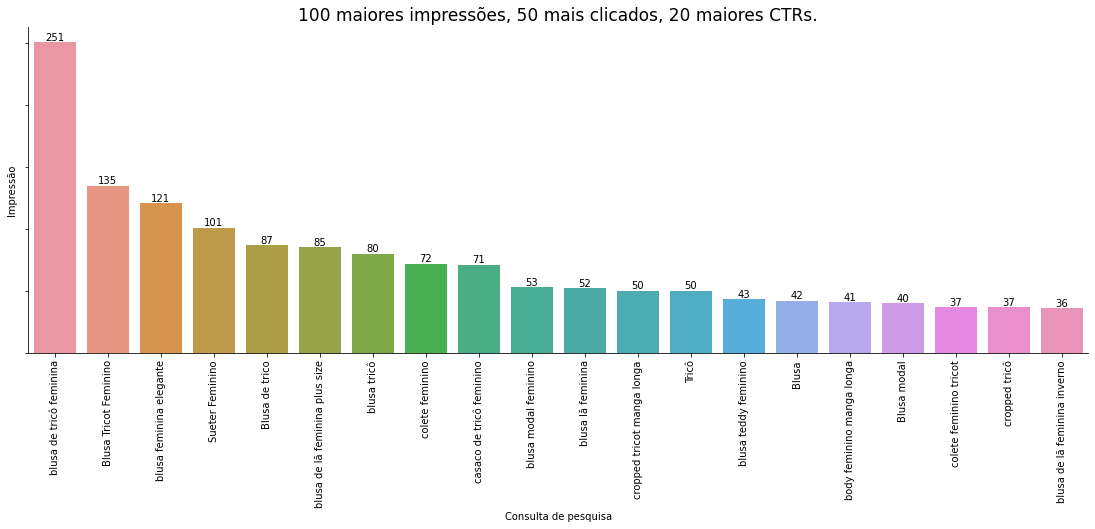

In [20]:
plot_bar('Impressão',SKU002_MesclaA,'100 maiores impressões, 50 mais clicados, 20 maiores CTRs.')

In [21]:
aproveitamento(SKU002_MesclaA,SKU002_semana,'Impressão')

Efetividade: 0.03641181666503092


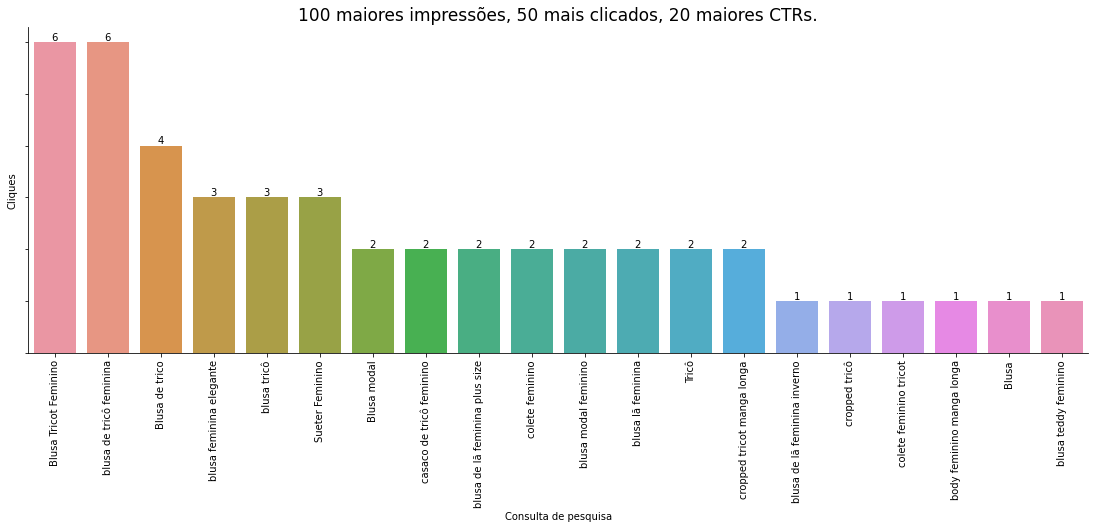

In [22]:
plot_bar('Cliques',SKU002_MesclaA,'100 maiores impressões, 50 mais clicados, 20 maiores CTRs.')

In [23]:
aproveitamento(SKU002_MesclaA,SKU002_semana,'Cliques')

Efetividade: 0.09038461538461538


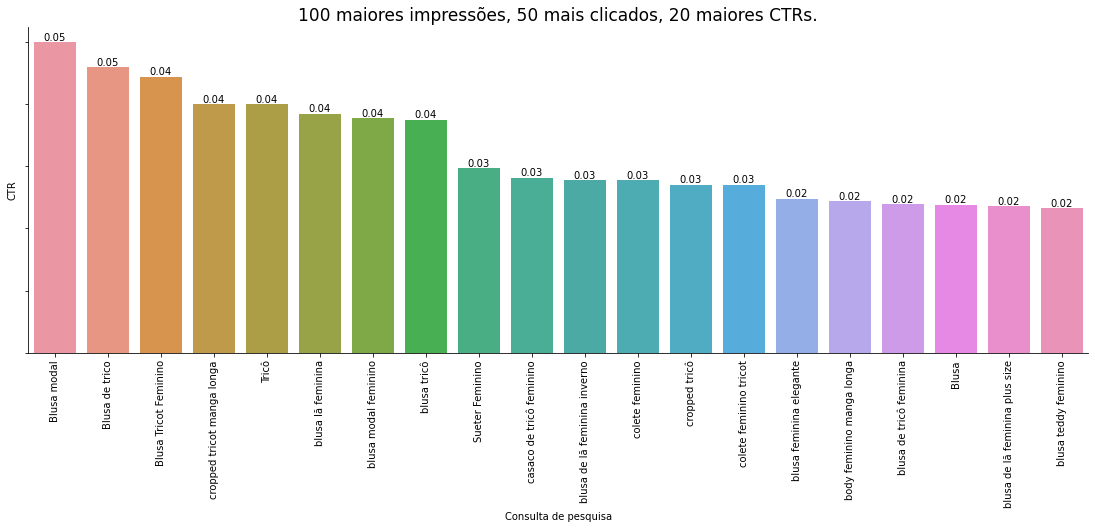

In [24]:
plot_bar('CTR',SKU002_MesclaA,'100 maiores impressões, 50 mais clicados, 20 maiores CTRs.')

100 maiores impressões, 50 maiores CTRs, 20 mais clicados.

In [25]:
SKU002_MesclaB = pareto(SKU002_semana, 'Impressão', 100, method = 'num')
SKU002_MesclaB = pareto(SKU002_MesclaB, 'CTR', 50, method = 'num')
SKU002_MesclaB = pareto(SKU002_MesclaB, 'Cliques', 20, method = 'num')

100
                     Efetividade: 0.2387869270782216
Percentual de itens remanecentes: 0.006165228113440197
50
                     Efetividade: 0.9777711417934463
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.6699029126213593
Percentual de itens remanecentes: 0.4


In [26]:
SKU002_MesclaB

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto Impressão,Pareto CTR,Pareto Cliques
11976,blusa tricot feminino,409,7,0.77,0.017115,0.11,1520,0.942530,7
9297,blusa de frio feminina,384,7,0.77,0.018229,0.11,1904,0.890475,14
9996,blusa de tricô feminina,251,6,0.66,0.023904,0.11,2798,0.655809,20
576,Blusa Tricot Feminino,135,6,0.66,0.044444,0.11,4569,0.140421,26
9659,blusa de lã feminina,352,5,0.55,0.014205,0.11,2256,1.054695,31
1857,Blusa de trico,87,4,0.44,0.045977,0.11,5888,0.095977,35
15531,sueter feminino,163,3,0.33,0.018405,0.11,4146,0.853897,38
293,Blusa De Frio Feminina,134,3,0.33,0.022388,0.11,4703,0.816974,41
14786,cropped manga longa,188,3,0.33,0.015957,0.11,3652,1.024617,44
10442,blusa feminina elegante,121,3,0.33,0.024793,0.11,5071,0.607514,47


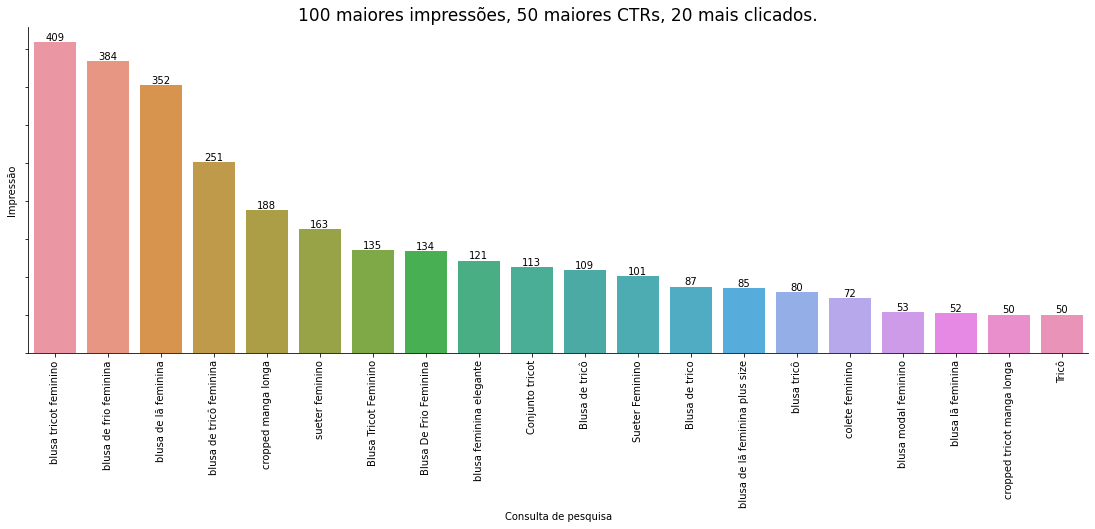

In [27]:
plot_bar('Impressão',SKU002_MesclaB,'100 maiores impressões, 50 maiores CTRs, 20 mais clicados.')

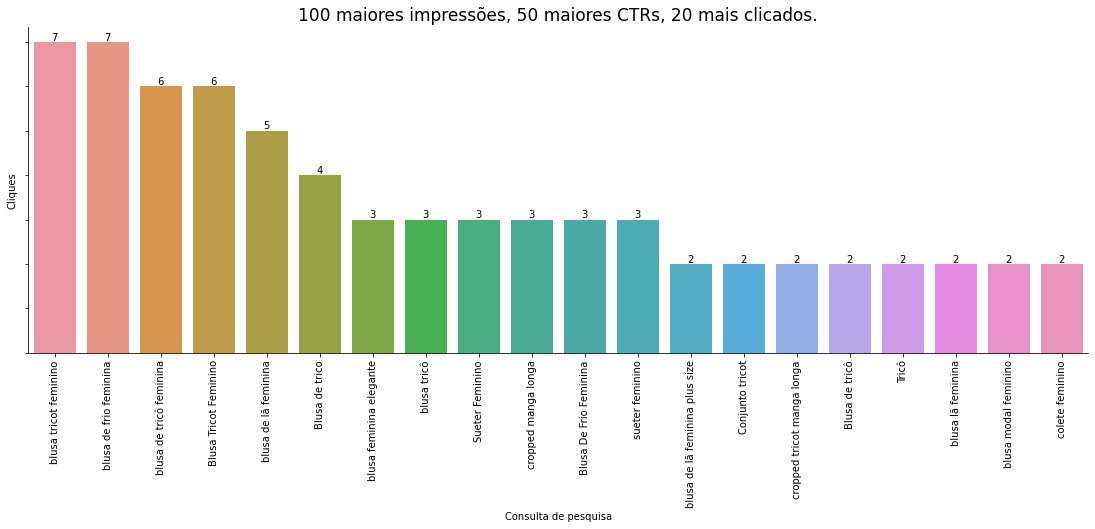

In [28]:
plot_bar('Cliques',SKU002_MesclaB,'100 maiores impressões, 50 maiores CTRs, 20 mais clicados.')

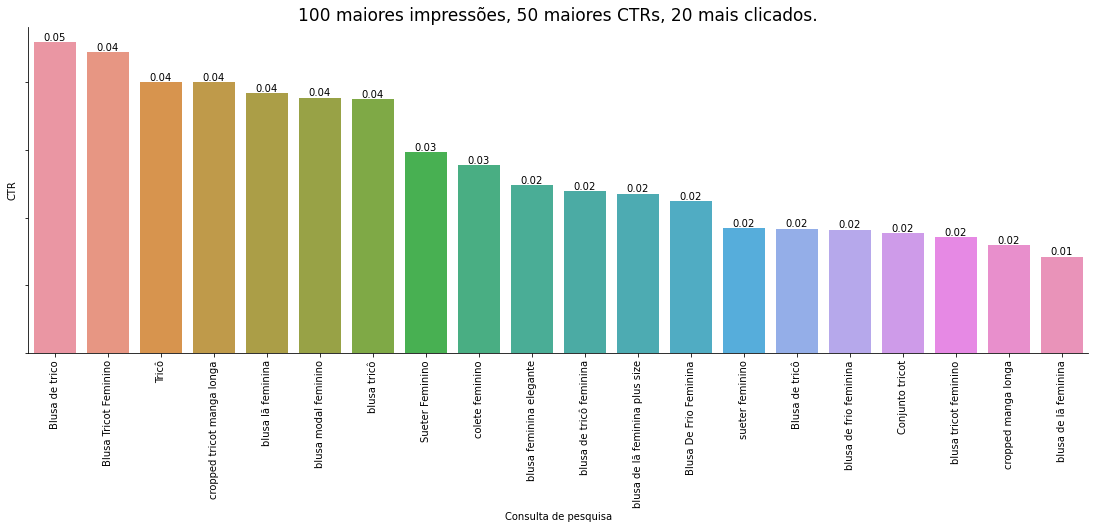

In [29]:
plot_bar('CTR',SKU002_MesclaB,'100 maiores impressões, 50 maiores CTRs, 20 mais clicados.')

100 mais clicados, 50 maiores CTRs, 20 maiores impressões.

In [30]:
SKU002_MesclaC = pareto(SKU002_semana, 'Cliques', 100, method = 'num')
SKU002_MesclaC = pareto(SKU002_MesclaC, 'CTR', 50, method = 'num')
SKU002_MesclaC = pareto(SKU002_MesclaC, 'Impressão', 20, method = 'num')

100
                     Efetividade: 0.35384615384615387
Percentual de itens remanecentes: 0.006165228113440197
50
                     Efetividade: 0.8852449489411237
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.5923566878980892
Percentual de itens remanecentes: 0.4


In [31]:
SKU002_MesclaC

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto Cliques,Pareto CTR,Pareto Impressão
4463,Blusas de tricot feminina,10,2,0.22,0.200000,0.11,117,23.850000,10
8213,Tricô nude,6,2,0.22,0.333333,0.11,113,22.533333,16
9703,blusa de lã feminino plus size,6,2,0.22,0.333333,0.11,123,20.866667,22
5165,Body manga longa bufante,6,2,0.22,0.333333,0.11,69,21.866667,28
2389,Blusa feminina lã,6,2,0.22,0.333333,0.11,93,21.533333,34
1684,Blusa de lã longa,5,1,0.11,0.200000,0.11,142,23.650000,39
11332,blusa morcego tricot,5,2,0.22,0.400000,0.11,67,18.400000,44
6848,Cropped de tricô feminina,5,2,0.22,0.400000,0.11,103,18.800000,49
4479,Blusas de tricô p,5,2,0.22,0.400000,0.11,109,19.200000,54
333,Blusa De Lã Plus Size Feminino,4,2,0.22,0.500000,0.11,111,6.500000,58


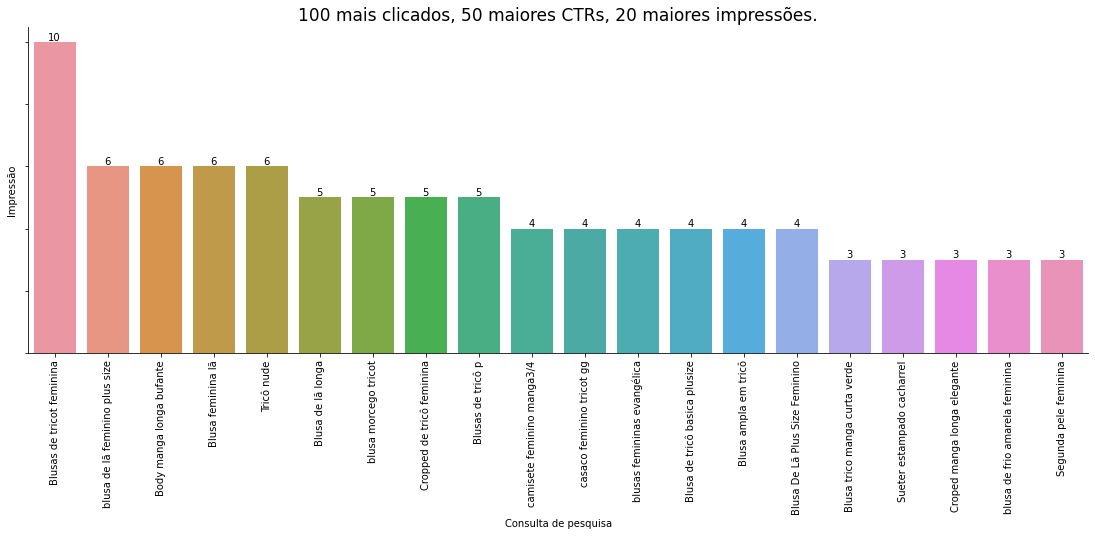

In [32]:
plot_bar('Impressão',SKU002_MesclaC,'100 mais clicados, 50 maiores CTRs, 20 maiores impressões.')

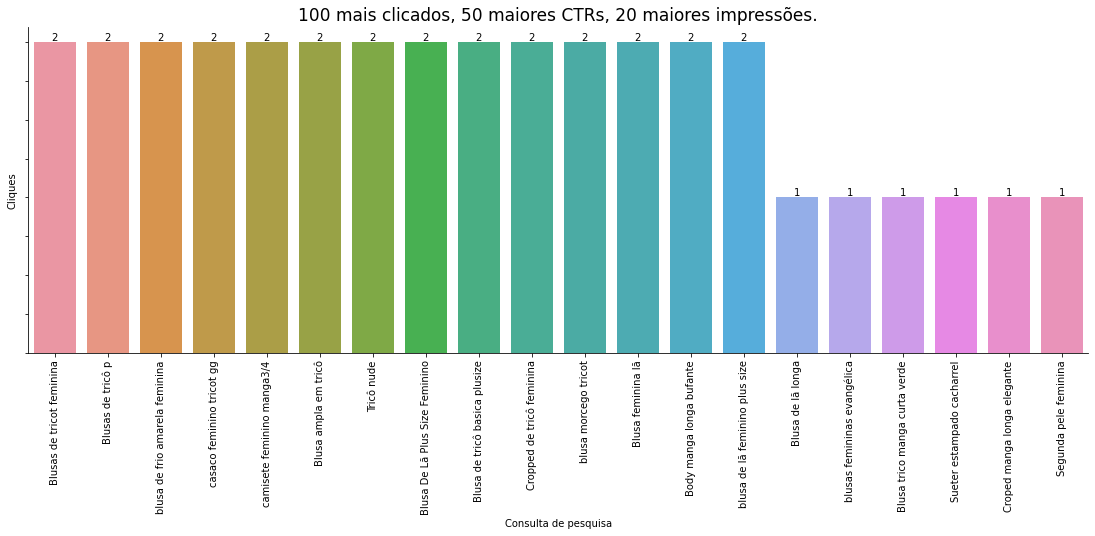

In [33]:
plot_bar('Cliques',SKU002_MesclaC,'100 mais clicados, 50 maiores CTRs, 20 maiores impressões.')

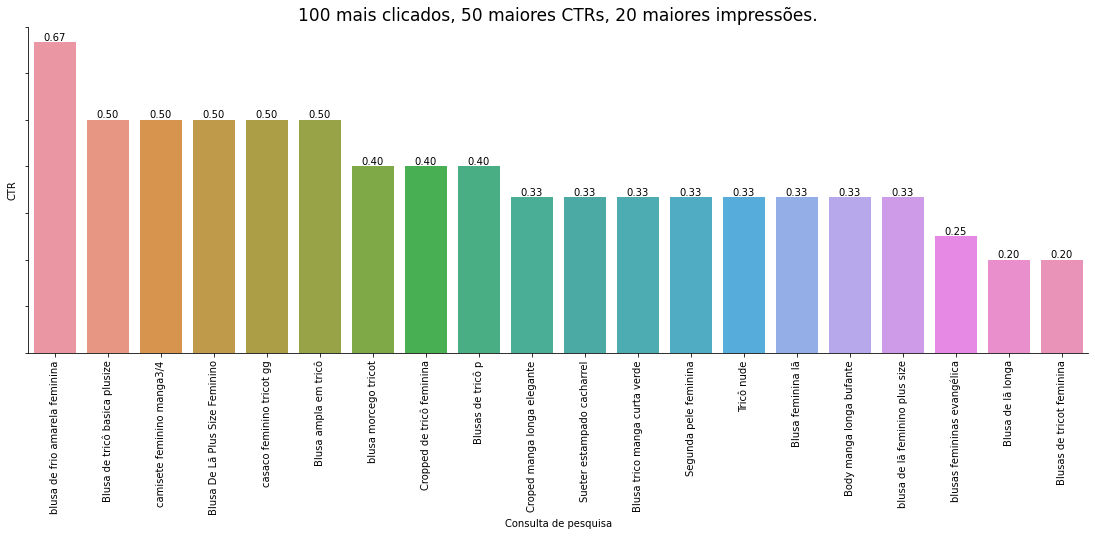

In [34]:
plot_bar('CTR',SKU002_MesclaC,'100 mais clicados, 50 maiores CTRs, 20 maiores impressões.')

100 mais clicados, 50 maiores impressões, 20 maiores CTRs.

In [35]:
SKU002_MesclaD = pareto(SKU002_semana, 'Cliques', 100, method = 'num')
SKU002_MesclaD = pareto(SKU002_MesclaD, 'Impressão', 50, method = 'num')
SKU002_MesclaD = pareto(SKU002_MesclaD, 'CTR', 20, method = 'num')

100
                     Efetividade: 0.35384615384615387
Percentual de itens remanecentes: 0.006165228113440197
50
                     Efetividade: 0.9628180039138943
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.7370780976938158
Percentual de itens remanecentes: 0.4


In [36]:
SKU002_MesclaD

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto Cliques,Pareto Impressão,Pareto CTR
2389,Blusa feminina lã,6,2,0.22,0.333333,0.11,93,3936,0.333333
8213,Tricô nude,6,2,0.22,0.333333,0.11,113,3930,0.666667
4463,Blusas de tricot feminina,10,2,0.22,0.200000,0.11,117,3880,0.866667
8814,blusa chiffon feminina,7,1,0.11,0.142857,0.11,181,3924,1.009524
11521,blusa plus size feminina manga longa,8,1,0.11,0.125000,0.11,154,3917,1.134524
14126,casaco tricô feminino,32,4,0.44,0.125000,0.11,43,3593,1.259524
9601,blusa de linho,33,4,0.44,0.121212,0.11,39,3561,1.380736
12072,blusa tricot plus size,18,2,0.22,0.111111,0.11,77,3814,1.491847
3638,Blusa trico plus,9,1,0.11,0.111111,0.11,139,3909,1.602958
8762,blusa canelada manga longa,10,1,0.11,0.100000,0.11,149,3900,1.702958


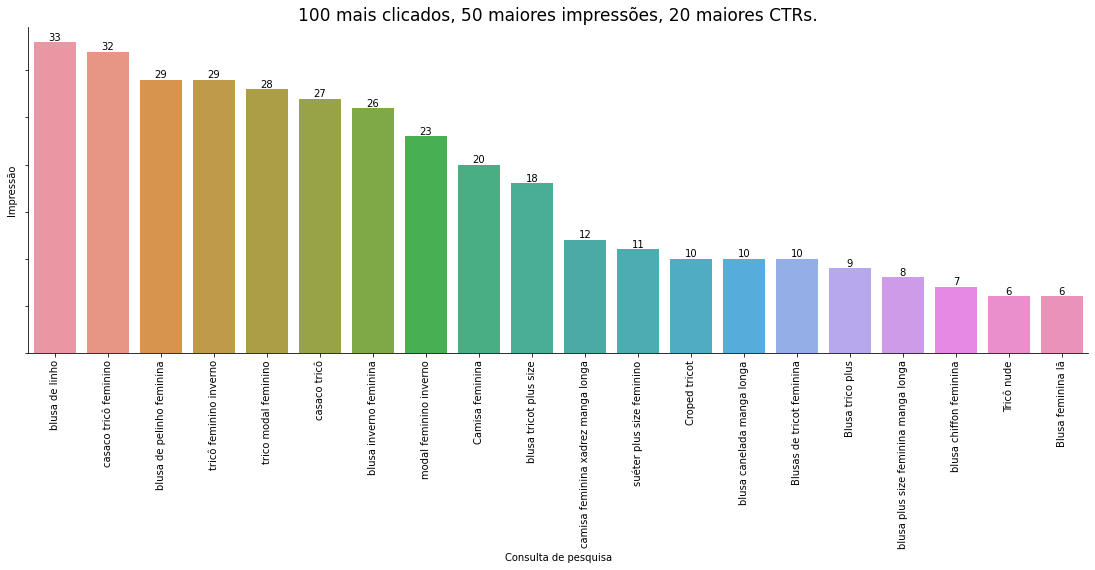

In [37]:
plot_bar('Impressão',SKU002_MesclaD,'100 mais clicados, 50 maiores impressões, 20 maiores CTRs.')

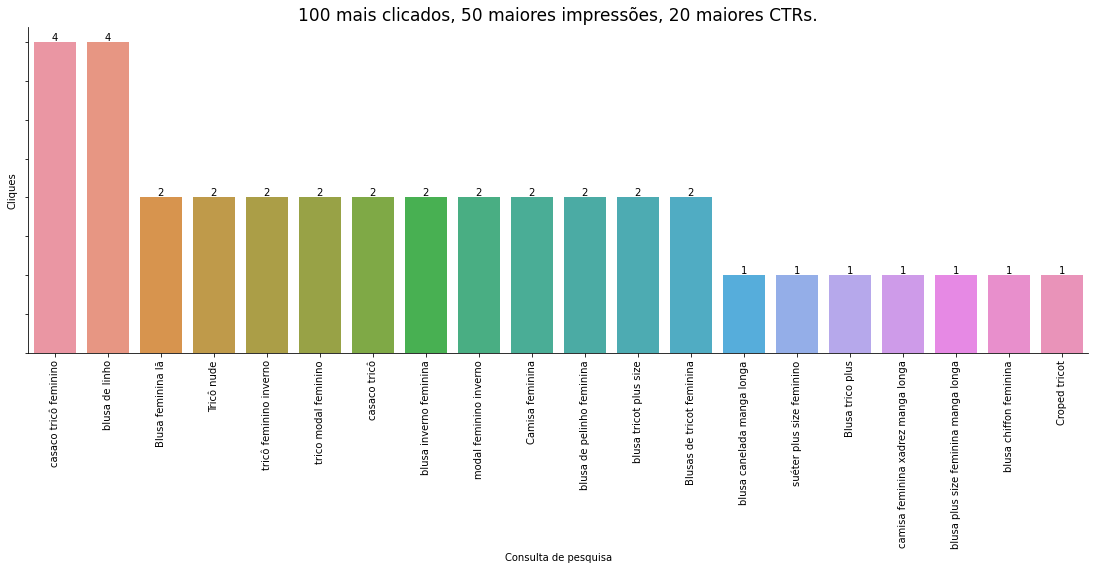

In [38]:
plot_bar('Cliques',SKU002_MesclaD,'100 mais clicados, 50 maiores impressões, 20 maiores CTRs.')

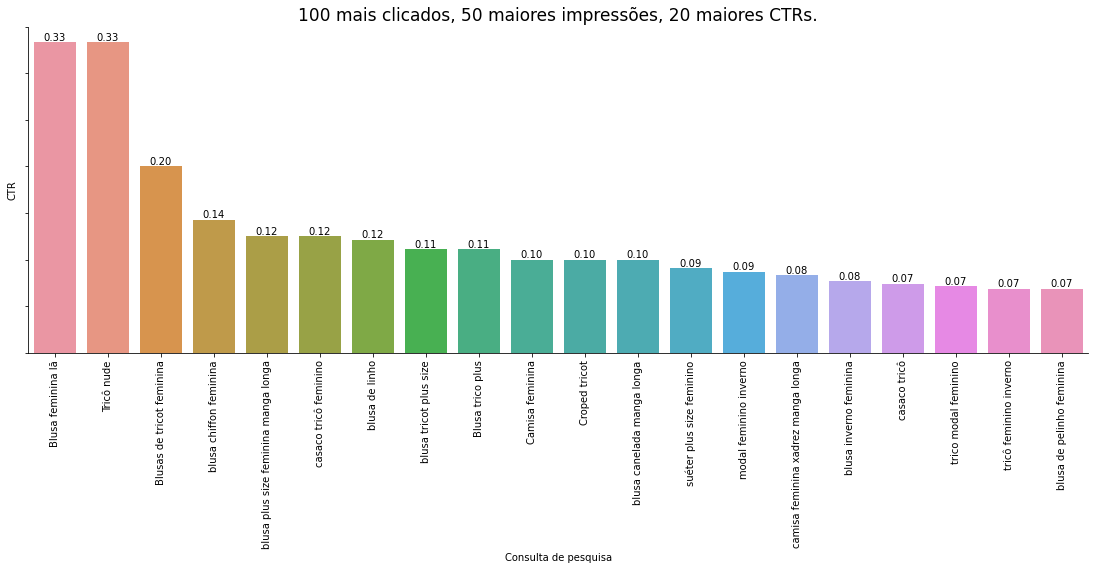

In [39]:
plot_bar('CTR',SKU002_MesclaD,'100 mais clicados, 50 maiores impressões, 20 maiores CTRs.')

100 maiores CTRs, 50 maiores impressões, 20 mais clicados.

In [40]:
SKU002_MesclaE = pareto(SKU002_semana, 'CTR', 100, method = 'num')
SKU002_MesclaE = pareto(SKU002_MesclaE, 'Impressão', 50, method = 'num')
SKU002_MesclaE = pareto(SKU002_MesclaE, 'Cliques', 20, method = 'num')

100
                     Efetividade: nan
Percentual de itens remanecentes: 0.006165228113440197
50
                     Efetividade: 0.6959459459459459
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.4642857142857143
Percentual de itens remanecentes: 0.4


C:\Users\fnsb\AppData\Local\Temp\ipykernel_6036\85931560.py:20: RuntimeWarning: invalid value encountered in double_scalars
  print('                     Efetividade:', (df_organizado['Pareto '+column].iloc[-1] / df[column].sum()))


In [41]:
SKU002_MesclaE

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto CTR,Pareto Impressão,Pareto Cliques
333,Blusa De Lã Plus Size Feminino,4,2,0.22,0.500000,0.11,inf,4,2
380,Blusa Duna Lisa Alice,3,2,0.22,0.666667,0.11,inf,11,4
9210,blusa de frio amarela feminina,3,2,0.22,0.666667,0.11,inf,14,6
10200,blusa em malha manga longa feminina,3,2,0.22,0.666667,0.11,inf,17,8
1946,Blusa de tricô basica plusize,4,2,0.22,0.500000,0.11,inf,8,10
9987,blusa de tricô com manga bufantes,2,2,0.22,1.000000,0.11,inf,99,12
4073,Blusa verde lã,2,1,0.11,0.500000,0.11,inf,83,13
1620,Blusa de lá branca,2,1,0.11,0.500000,0.11,inf,67,14
8051,Tricot onça colorida,2,1,0.11,0.500000,0.11,inf,69,15
7402,Produtos yeesco,2,1,0.11,0.500000,0.11,inf,71,16


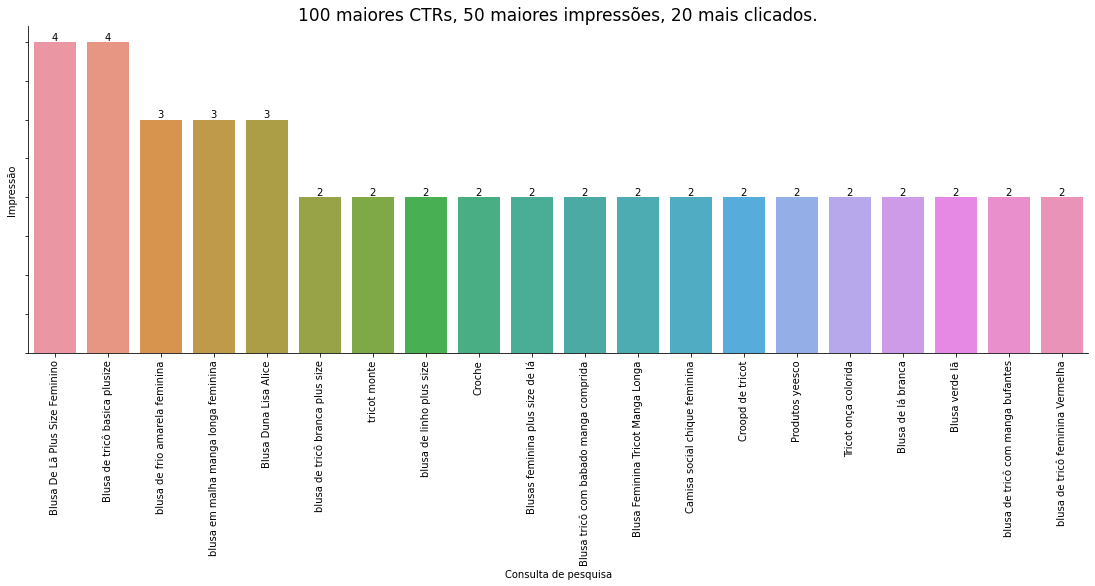

In [42]:
plot_bar('Impressão',SKU002_MesclaE,'100 maiores CTRs, 50 maiores impressões, 20 mais clicados.')

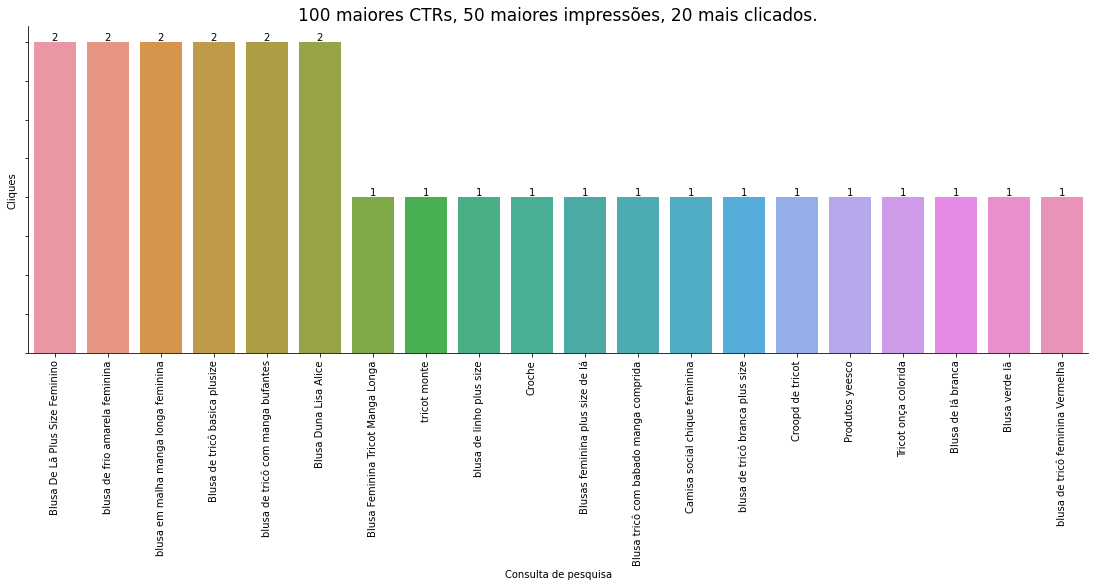

In [43]:
plot_bar('Cliques',SKU002_MesclaE,'100 maiores CTRs, 50 maiores impressões, 20 mais clicados.')

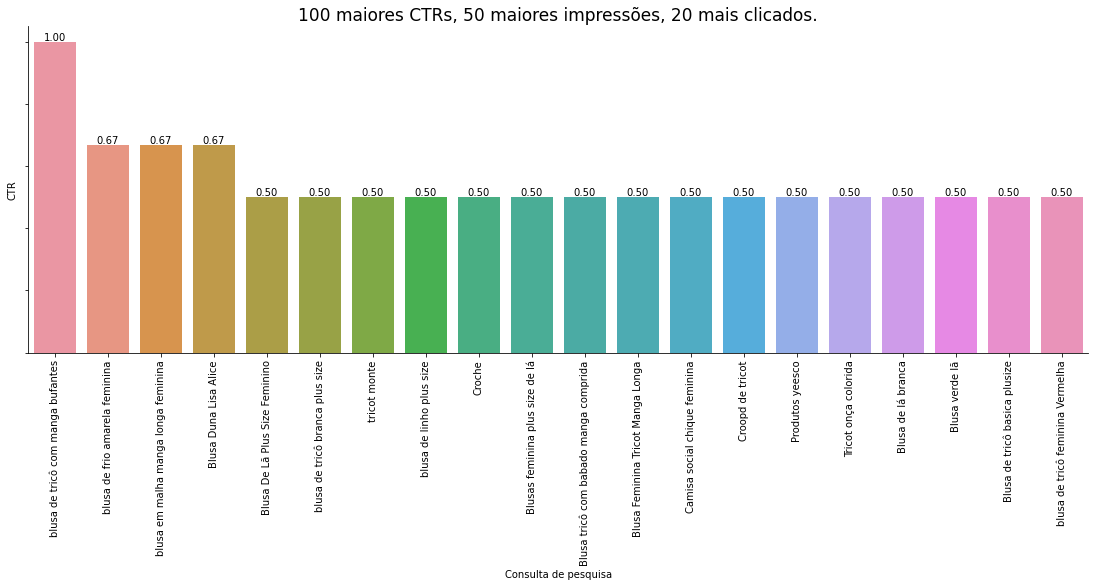

In [44]:
plot_bar('CTR',SKU002_MesclaE,'100 maiores CTRs, 50 maiores impressões, 20 mais clicados.')

100 maiores CTRs, 50 mais clicados, 20 maiores impressões.

In [45]:
SKU002_MesclaF = pareto(SKU002_semana, 'CTR', 100, method = 'num')
SKU002_MesclaF = pareto(SKU002_MesclaF, 'Cliques', 50, method = 'num')
SKU002_MesclaF = pareto(SKU002_MesclaF, 'Impressão', 20, method = 'num')

100
                     Efetividade: nan
Percentual de itens remanecentes: 0.006165228113440197
50
                     Efetividade: 0.5283018867924528
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.46534653465346537
Percentual de itens remanecentes: 0.4


C:\Users\fnsb\AppData\Local\Temp\ipykernel_6036\85931560.py:20: RuntimeWarning: invalid value encountered in double_scalars
  print('                     Efetividade:', (df_organizado['Pareto '+column].iloc[-1] / df[column].sum()))


In [46]:
SKU002_MesclaF

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto CTR,Pareto Cliques,Pareto Impressão
333,Blusa De Lã Plus Size Feminino,4,2,0.22,0.500000,0.11,inf,12,4
1946,Blusa de tricô basica plusize,4,2,0.22,0.500000,0.11,inf,4,8
380,Blusa Duna Lisa Alice,3,2,0.22,0.666667,0.11,inf,6,11
9210,blusa de frio amarela feminina,3,2,0.22,0.666667,0.11,inf,8,14
10200,blusa em malha manga longa feminina,3,2,0.22,0.666667,0.11,inf,10,17
9987,blusa de tricô com manga bufantes,2,2,0.22,1.000000,0.11,inf,2,19
5525,Camisa Longa Feminina,2,1,0.11,0.500000,0.11,inf,45,21
4864,Blusinha de manga longa,2,1,0.11,0.500000,0.11,inf,37,23
1620,Blusa de lá branca,2,1,0.11,0.500000,0.11,inf,38,25
8051,Tricot onça colorida,2,1,0.11,0.500000,0.11,inf,39,27


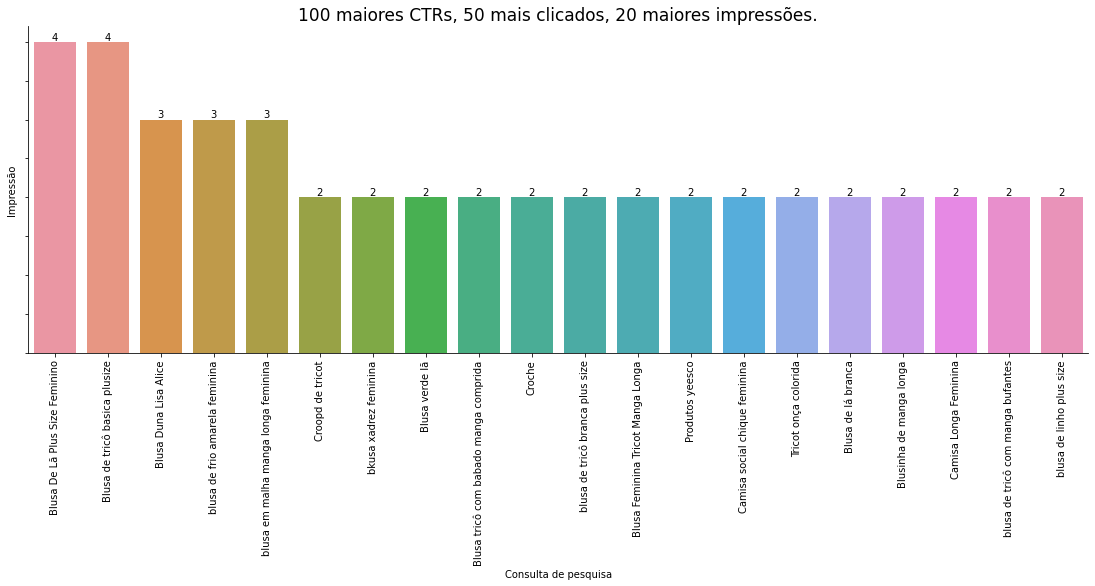

In [47]:
plot_bar('Impressão',SKU002_MesclaF,'100 maiores CTRs, 50 mais clicados, 20 maiores impressões.')

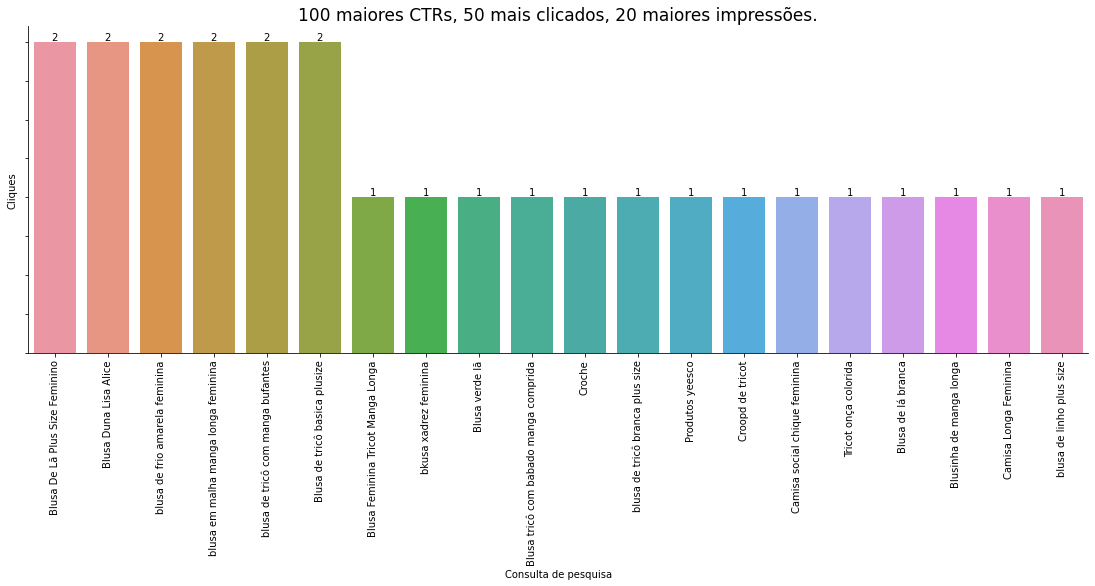

In [48]:
plot_bar('Cliques',SKU002_MesclaF,'100 maiores CTRs, 50 mais clicados, 20 maiores impressões.')

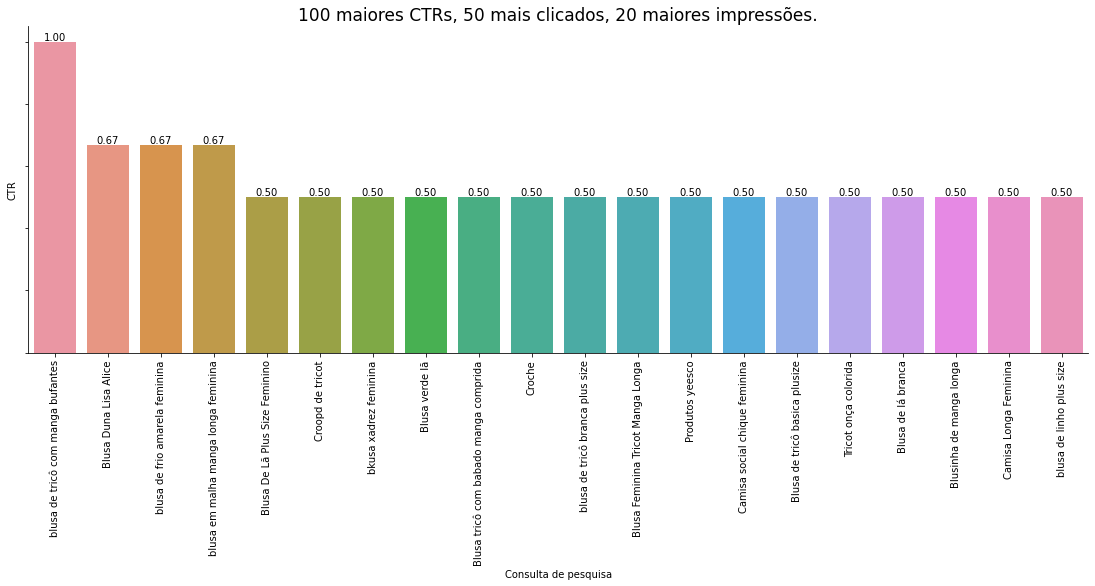

In [49]:
plot_bar('CTR',SKU002_MesclaF,'100 maiores CTRs, 50 mais clicados, 20 maiores impressões.')

### Efetividade

In [50]:
SKU002_MesclaA['Impressão'].iloc

In [51]:
SKU002_semana
Mesclas = [SKU002_MesclaA,SKU002_MesclaB,SKU002_MesclaC,SKU002_MesclaD,SKU002_MesclaE,SKU002_MesclaF]
Medidas = ['Impressão','Cliques','CTR']

Efetividade = pd.DataFrame()

Efetividade['Mesclas'] = ['SKU002_MesclaA','SKU002_MesclaB','SKU002_MesclaC','SKU002_MesclaD','SKU002_MesclaE','SKU002_MesclaF']

for i in Medidas: # Vertical
    Efetividade[i] = None
    for j in range(len(Mesclas)): # Horizontal
        Efetividade[i].iloc[j] = Mesclas[j][i].sum() / SKU002_semana[i].sum()
        

Efetividade

,Mesclas,Impressão,Cliques,CTR
0,SKU002_MesclaA,0.036412,0.090385,0.0
1,SKU002_MesclaB,0.073339,0.132692,0.0
2,SKU002_MesclaC,0.002282,0.065385,0.0
3,SKU002_MesclaD,0.008686,0.071154,0.0
4,SKU002_MesclaE,0.001153,0.05,0.0
5,SKU002_MesclaF,0.001153,0.05,0.0


### Lista de Palavras-chave

In [54]:
SKU002_Mescla = pd.concat([SKU002_MesclaA,SKU002_MesclaB,SKU002_MesclaC,SKU002_MesclaD,SKU002_MesclaE,SKU002_MesclaF])
print(len(SKU002_Mescla))
SKU002_Mescla_csv = SKU002_Mescla['Consulta de pesquisa'].drop_duplicates()
print(len(SKU002_Mescla_csv))

120
85


In [53]:
SKU002_Mescla_csv.to_csv('SKU002_Palavras_Filtradas.csv', index=False)